In [335]:
#guides
#https://stackoverflow.com/questions/47944463/specify-input-argument-with-kerasregressor
#https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
#https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

import pandas
import scipy
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import scipy.stats as st
import ZCA as zca

from pandas import read_csv
import tensorflow as tf
from tensorflow import keras
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


In [330]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
all_data = pd.read_csv('/mnt/distvol/states.csv')

In [ ]:
seed = 42

,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
count,3.50e+01,3.50e+01,3.50e+01,3.50e+01,3.50e+01,3.50e+01,3.50e+01,3.50e+01,3.50e+01,3.50e+01
mean,-3.89e-16,3.87e-16,2.50e-16,1.03e-16,9.58e-16,1.78e-15,-2.63e-16,-5.46e-16,2.41e-16,-5.08e-17
std,1.01e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,-1.65e+00,-1.86e+00,-4.34e+00,-1.28e+00,-1.42e+00,-2.16e+00,-2.19e+00,-1.49e+00,-1.71e+00,-8.48e-01
25%,-8.36e-01,-5.07e-01,-3.66e-02,-6.02e-01,-6.99e-01,-6.23e-01,-5.83e-01,-8.73e-01,-6.80e-01,-6.93e-01
50%,-1.59e-01,-7.57e-02,2.36e-01,-3.75e-01,3.46e-04,1.98e-01,1.56e-01,2.46e-01,-1.94e-01,-2.69e-01
75%,7.05e-01,4.74e-01,4.77e-01,5.52e-01,3.64e-01,5.72e-01,4.88e-01,6.01e-01,5.23e-01,2.73e-01
max,2.96e+00,1.91e+00,9.61e-01,2.42e+00,2.80e+00,1.70e+00,3.05e+00,2.13e+00,2.05e+00,3.70e+00


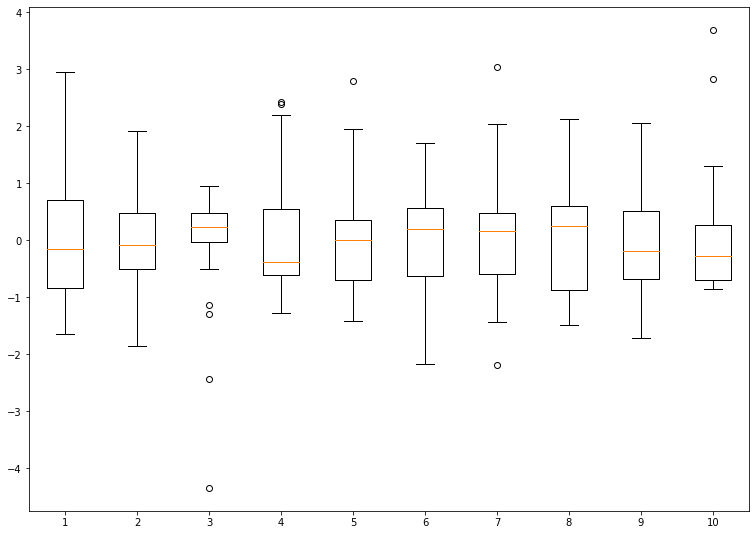

,Poverty,Infant Mort,White,Crime,Doctors,Traf Deaths,University,Unemployed,Income,Population
Poverty,1.00,0.08,-0.24,0.11,0.06,0.20,-0.03,0.18,-0.83,0.29
Infant Mort,0.08,1.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
White,-0.24,-0.00,1.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
Crime,0.11,-0.00,0.00,1.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
Doctors,0.06,-0.00,-0.00,-0.00,1.00,0.00,0.00,0.00,-0.00,-0.00
Traf Deaths,0.20,0.00,0.00,0.00,0.00,1.00,-0.00,-0.00,0.00,0.00
University,-0.03,0.00,0.00,-0.00,0.00,-0.00,1.00,-0.00,0.00,-0.00
Unemployed,0.18,0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,-0.00
Income,-0.83,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,1.00,-0.00
Population,0.29,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,1.00


In [290]:
from sklearn.model_selection import train_test_split

tsize = .3

np.random.seed(seed)
tf.random.set_seed(seed)

#exclude state
train, test = train_test_split(all_data.iloc[:,1:], test_size=tsize, shuffle=True)
# load dataset

#exclude y
trf = zca.ZCA().fit(train.iloc[:,1:])

#y
std = np.std(np.array(train.iloc[:,0]))
mean = np.mean(np.array(train.iloc[:,0]))
Z = (np.array(train.iloc[:,0])-mean)/std

X_train = pd.DataFrame(trf.transform(train.iloc[:,1:]))
X_test = trf.transform(test.iloc[:,1:])
Y_test = (test.iloc[:,1]-mean)/std
#norm_ = scipy.stats.norm.cdf(Z) # calculate the cdf - also diascrete
#norm_=Z

Y_train = pd.DataFrame(Z)

data = pd.concat([Y_train,X_train],axis=1)

data.columns=all_data.iloc[:,1:].columns

display(data.describe())

pd.set_option("precision", 2)

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(pd.DataFrame(data))
plt.show()

pd.DataFrame(data).corr().style.background_gradient(cmap ='viridis')\
    .set_properties(**{'font-size': '10px'})

In [291]:
e = 100
b = 5

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


def baseline_model(x):
    def bm():
        # create model
        model = Sequential()
        model.add(Dense(x, input_dim=x, kernel_initializer='normal', activation='relu'))
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        model.compile(loss='MAPE', optimizer='adam')
        return model
    return bm

inpt  = len(X_train.columns)

estimator = KerasRegressor(build_fn=baseline_model(inpt), epochs=e, batch_size=b, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_train, Y_train, cv=kfold)
print("Baseline: %.2f (%.2f) MAPE" % (results.mean(), results.std()))


Baseline: -169.06 (274.87) MAPE


In [292]:

np.random.seed(seed)
tf.random.set_seed(seed)


model = Sequential()
model.add(Dense(len(X_train.columns), input_dim=len(X_train.columns), kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

#history = model.fit(X_train, Y_train, epochs=e,batch_size=b)
model.fit(X_train, Y_train, epochs=e, batch_size=b, verbose=0)


Poverty    10.7
dtype: float64

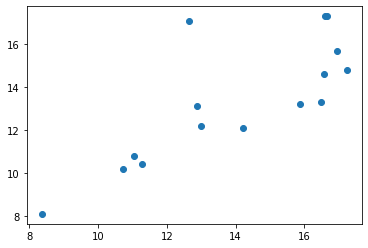

rmse 3.7085622390887107
mape Poverty    10.7
dtype: float64


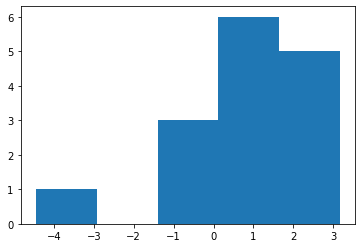

In [340]:

pred = model.predict(X_test)

#predicted = pd.DataFrame(st.norm.ppf(pred)*std+mean)
predicted = pd.DataFrame(pred*std+mean)
#model.predict(X_test)*std+mean
predicted.index=test.index
predicted.columns=pd.DataFrame(test.iloc[:,0]).columns

actual = pd.DataFrame(test.iloc[:,0])
plt.scatter(predicted, actual)

plt.show()

plt.hist(predicted-actual, bins='auto')  # arguments are passed to np.histogram

rmse = mean_squared_error(actual, predicted, squared=True)
mape = MAPE(actual, predicted)

print("rmse",rmse)
print("mape",mape)